In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# For scraping reviews in google play
!pip install -q google_play_scraper
from google_play_scraper import app, Sort, reviews_all

# For sentiment analysis
!pip install -q transformers
from transformers import pipeline
import nltk
import torch
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
!pip install -q pyyaml==5.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


## Downsampling the Data

The data scraped were not balanced. Unfortunately I am only able to scrape 316410 rows of data from shopee while I have 788257 rows of data for Lazada. For some reason I am only able to scrape data from shopee until 2021-06-15.To address this issue I am down sampling much of the lazada dataset and some of shopee dataset into a sample of 150000 for each.

In [13]:
lazada_reviews_clean_df = pd.read_csv('lazada_reviews_clean.csv', parse_dates = ['at', 'repliedAt'])
shopee_reviews_clean_df = pd.read_csv('shopee_reviews_clean.csv', parse_dates = ['at', 'repliedAt'])

In [14]:
lazada_reviews_clean_df.shape

(336202, 12)

In [15]:
shopee_reviews_clean_df.shape

(155583, 12)

In [20]:
final_sample_size = 150000

# Lazada Downsampling
downsampled_lazada_df = lazada_reviews_clean_df.sample(n=final_sample_size, random_state=42)
downsampled_lazada_df.reset_index(drop=True, inplace=True)

# Shopee Downsampling
downsampled_shopee_df = shopee_reviews_clean_df.sample(n=final_sample_size, random_state=42)
downsampled_shopee_df.reset_index(drop=True, inplace=True)

In [21]:
downsampled_lazada_df.shape

(150000, 12)

In [22]:
downsampled_shopee_df.shape

(150000, 12)

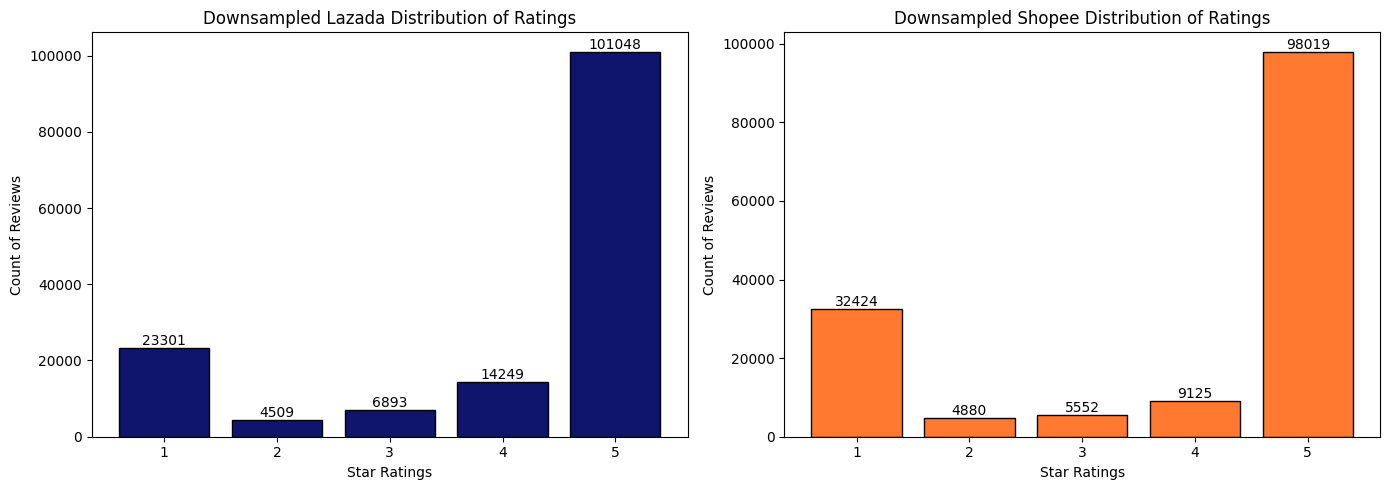

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

lazada_star_counts = downsampled_lazada_df['score'].value_counts().sort_index()
ax1.bar(lazada_star_counts.index, lazada_star_counts, color='#0f146d', edgecolor='black')
ax1.set_title('Downsampled Lazada Distribution of Ratings')
ax1.set_xlabel('Star Ratings')
ax1.set_ylabel('Count of Reviews')
ax1.set_xticks(lazada_star_counts.index)
ax1.set_xticklabels(lazada_star_counts.index)

for i, count in enumerate(lazada_star_counts):
    ax1.text(lazada_star_counts.index[i], count, str(count), ha='center', va='bottom')

shopee_star_counts = downsampled_shopee_df['score'].value_counts().sort_index()
ax2.bar(shopee_star_counts.index, shopee_star_counts, color='#ff7930', edgecolor='black')
ax2.set_title('Downsampled Shopee Distribution of Ratings')
ax2.set_xlabel('Star Ratings')
ax2.set_ylabel('Count of Reviews')
ax2.set_xticks(shopee_star_counts.index)
ax2.set_xticklabels(shopee_star_counts.index)

for i, count in enumerate(shopee_star_counts):
    ax2.text(shopee_star_counts.index[i], count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sentiment Analysis

### Create another column called sentimentLabel that will classify the reviews into **1** (positive reviews), which will be assigned to 4-5 star reviews, and **0** (negative reviews), which will be assigned to 1-3 star reviews.

### Lazada

In [24]:
downsampled_lazada_df['sentimentLabel'] = downsampled_lazada_df['score'].map(lambda x: 0 if x < 4 else 1)

In [25]:
downsampled_lazada_df['sentimentLabel'].value_counts()

1    115297
0     34703
Name: sentimentLabel, dtype: int64

### Shopee

In [26]:
downsampled_shopee_df['sentimentLabel'] = downsampled_shopee_df['score'].map(lambda x: 0 if x < 4 else 1)

In [27]:
downsampled_shopee_df['sentimentLabel'].value_counts()

1    107144
0     42856
Name: sentimentLabel, dtype: int64

### Creating a new dataframe that will include all columns which are going to be used in sentiment analysis

### Lazada

In [29]:
lazada_sen_df = downsampled_lazada_df[['content', 'contentAdj', 'score', 'sentimentLabel']]

In [30]:
lazada_sen_df.columns

Index(['content', 'contentAdj', 'score', 'sentimentLabel'], dtype='object')

### Shopee

In [31]:
shopee_sen_df = downsampled_shopee_df[['content', 'contentAdj', 'score', 'sentimentLabel']]

In [32]:
shopee_sen_df.columns

Index(['content', 'contentAdj', 'score', 'sentimentLabel'], dtype='object')

# VADER Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool VADER is lexicon-based and adapted to social media sentiments and is also a bag of words approach.

### Lazada

In [ ]:
laz_rep_text = (lazada_sen_df.loc[5378  , 'content'])

In [ ]:
laz_rep_text

'Lazada sucks. They have "Quality Review" badges, but almost all reviews have it just because it has a picture, doesn\'t matter if the review is fake or is of LOW QUALITY. Uploading photos and videos for reviewing products are also so much of a hassle. Viewing in landscape mode on a tablet is horrendous. Tons of useless "discount" notifications that lead you nowhere when clicking on it. So many potential features, yet they refuse to optimize their app and website. Big discounts my *ss.'

In [ ]:
laz_txt_tokens = nltk.word_tokenize(laz_rep_text)
laz_txt_tokens[:10]

['Lazada',
 'sucks',
 '.',
 'They',
 'have',
 '``',
 'Quality',
 'Review',
 "''",
 'badges']

In [ ]:
laz_txt_pos = nltk.pos_tag(laz_txt_tokens)
laz_txt_pos[:10]

[('Lazada', 'NNP'),
 ('sucks', 'NNS'),
 ('.', '.'),
 ('They', 'PRP'),
 ('have', 'VBP'),
 ('``', '``'),
 ('Quality', 'NNP'),
 ('Review', 'NNP'),
 ("''", "''"),
 ('badges', 'NNS')]

In [ ]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(laz_rep_text)

{'neg': 0.225, 'neu': 0.732, 'pos': 0.043, 'compound': -0.9528}

In [ ]:
laz_vader_results = {}
for i, row in lazada_sen_df.iterrows():
    text = row['content']
    res = sia.polarity_scores(text)
    laz_vader_results[i] = res

In [ ]:
laz_sia_df = pd.DataFrame(laz_vader_results).T
laz_sia_df['Id'] = range(len(laz_sia_df))
lazada_sen_df['Id'] = range(len(lazada_sen_df))
laz_vader_df = laz_sia_df.merge(lazada_sen_df, how='left', on='Id')

<ipython-input-41-61e57978133f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lazada_sen_df['Id'] = range(len(lazada_sen_df))


In [ ]:
laz_vader_df.head(5)

,neg,neu,pos,compound,Id,content,contentAdj,score,sentimentLabel
0,0.0,0.323,0.677,0.6369,0,i love this app...,love app,5,1
1,0.0,0.417,0.583,0.6369,1,The best online apps,best online apps,5,1
2,0.0,0.500,0.500,0.7184,2,Please add search feature for reward coin prod...,please add search feature reward coin products,4,1
3,0.0,0.674,0.326,0.4404,3,Easy to order and cash on delivery.,easy order cash delivery,5,1
4,0.0,0.192,0.808,0.6369,4,I love it... 😘,love,5,1


In [ ]:
laz_column_mapping = {
    'neg': 'vader_neg',
    'neu': 'vader_neu',
    'pos': 'vader_pos',
    'compound': 'vader_compound'
}

laz_vader_df = laz_vader_df.rename(columns=laz_column_mapping)
laz_vader_df.columns

Index(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'Id',
       'content', 'contentAdj', 'score', 'sentimentLabel'],
      dtype='object')

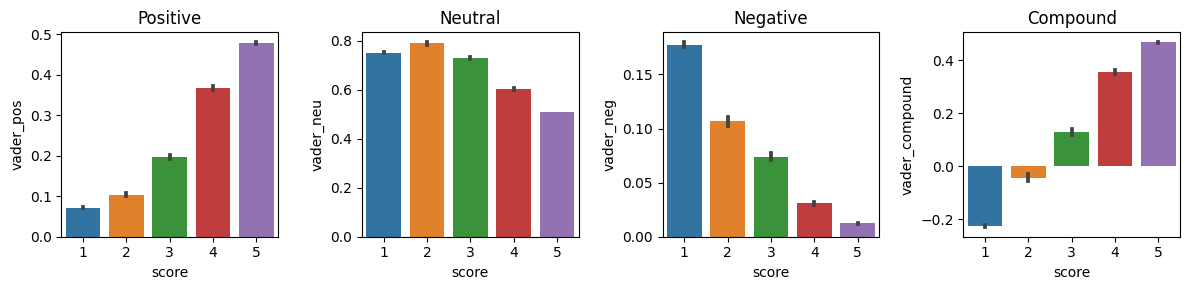

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
sns.barplot(data=laz_vader_df, x='score', y='vader_pos', ax=axs[0])
sns.barplot(data=laz_vader_df, x='score', y='vader_neu', ax=axs[1])
sns.barplot(data=laz_vader_df, x='score', y='vader_neg', ax=axs[2])
sns.barplot(data=laz_vader_df, x='score', y='vader_compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

In [ ]:
# Create a range of compound score thresholds
laz_thresholds_vader = np.linspace(-1, 1, 1000)

# Initialize lists to store accuracy scores and predicted labels
laz_accuracy_scores_vader = []
laz_predicted_labels_vader = []

# Iterate through the threshold range and calculate accuracy for each threshold
for threshold in laz_thresholds_vader:
    laz_vader_prediction = laz_vader_df['vader_compound'].map(lambda x: 1 if x > threshold else 0)
    accuracy = accuracy_score(laz_vader_df['sentimentLabel'], laz_vader_prediction)
    laz_accuracy_scores_vader.append(accuracy)
    laz_predicted_labels_vader.append(laz_vader_prediction)

# Find the threshold that maximizes accuracy
laz_best_threshold_vader = laz_thresholds_vader[np.argmax(laz_accuracy_scores_vader)]
laz_best_accuracy_vader = max(laz_accuracy_scores_vader)

VADER's best accuracy score:  0.8567866666666667
Compound score threshold:  -0.0030030030030030463


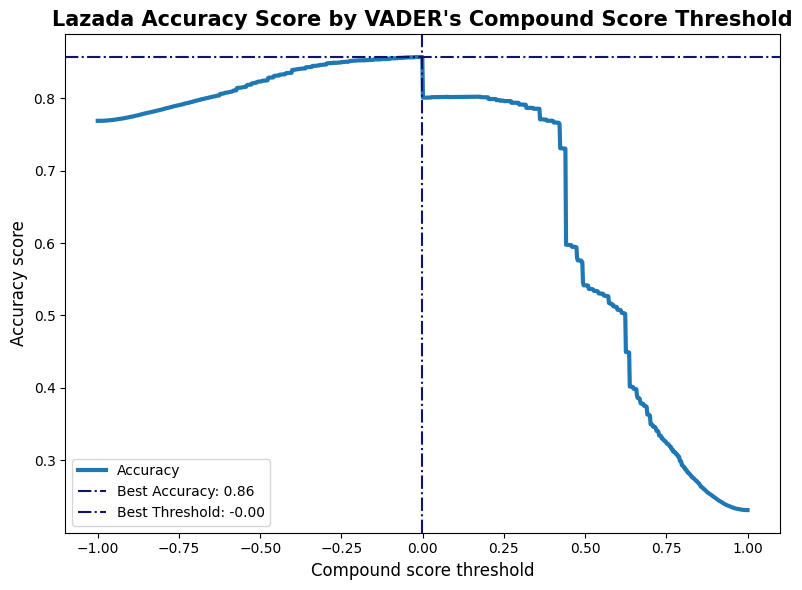

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the accuracy scores against compound score thresholds
plt.plot(laz_thresholds_vader, laz_accuracy_scores_vader, linewidth=3, label='Accuracy')

# Highlight the best accuracy score and threshold
plt.axhline(laz_best_accuracy_vader, linestyle='dashdot', color='#0f146d', label=f'Best Accuracy: {laz_best_accuracy_vader:.2f}')
plt.axvline(laz_best_threshold_vader, linestyle='dashdot', color='#0f146d', label=f'Best Threshold: {laz_best_threshold_vader:.2f}')
plt.title("Lazada Accuracy Score by VADER's Compound Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('Compound score threshold', size=12)
plt.legend()
plt.tight_layout()

print("VADER's best accuracy score: ", max(laz_accuracy_scores_vader))
print('Compound score threshold: ', laz_thresholds_vader[np.argmax(laz_accuracy_scores_vader)])

In [ ]:
# Prediction with compound threshold of -0.0030030030030030463
laz_vader_df['vaderPrediction'] = laz_vader_df['vader_compound'].map(lambda x: 1 if x > laz_thresholds_vader[np.argmax(laz_accuracy_scores_vader)] else 0)

In [ ]:
# Confusion matrix
laz_cm_vader = confusion_matrix(laz_vader_df['sentimentLabel'], laz_vader_df['vaderPrediction'])
laz_cm_vader_df = pd.DataFrame(laz_cm_vader, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
laz_cm_vader_df

,Predicted Positive Review,Predicted Negative Review
Actual Positive Review,17149,17554
Actual Negative Review,3928,111369


In [ ]:
# Classification report
print(classification_report(laz_vader_df['sentimentLabel'], laz_vader_df['vaderPrediction']))

              precision    recall  f1-score   support

           0       0.81      0.49      0.61     34703
           1       0.86      0.97      0.91    115297

    accuracy                           0.86    150000
   macro avg       0.84      0.73      0.76    150000
weighted avg       0.85      0.86      0.84    150000



In [ ]:
# Positive reviews that were predicted to be positive reviews
laz_vader_true_pos = laz_vader_df[(laz_vader_df['sentimentLabel']==1) & (laz_vader_df['vaderPrediction']==1)]
laz_vader_true_pos.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
0,0.0,0.323,0.677,0.6369,0,i love this app...,love app,5,1,1
1,0.0,0.417,0.583,0.6369,1,The best online apps,best online apps,5,1,1
2,0.0,0.500,0.500,0.7184,2,Please add search feature for reward coin prod...,please add search feature reward coin products,4,1,1
3,0.0,0.674,0.326,0.4404,3,Easy to order and cash on delivery.,easy order cash delivery,5,1,1
4,0.0,0.192,0.808,0.6369,4,I love it... 😘,love,5,1,1


In [ ]:
# Negative reviews that were predicted to be negative reviews
laz_vader_true_neg = laz_vader_df[(laz_vader_df['sentimentLabel']==0) & (laz_vader_df['vaderPrediction']==0)]
laz_vader_true_neg.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
7,0.051,0.893,0.056,-0.1877,7,Their customer service is not helpful. Do not ...,customer service helpful ever pay debit pay it...,1,0,0
17,0.120,0.880,0.000,-0.2584,17,Can't play video in the product page. It's bee...,play video product page months obviously bug s...,2,0,0
35,0.346,0.654,0.000,-0.5719,35,Downloaded this app because i was directed by ...,downloaded app directed scam,1,0,0
45,0.130,0.870,0.000,-0.4019,45,I also encountered problem in purchasing one i...,also encountered problem purchasing one item a...,2,0,0
74,0.208,0.700,0.093,-0.6959,74,lazada is so prank..posting 49 pisos but when ...,lazada prank posting pisos u add cart posting ...,1,0,0


In [ ]:
# Positive reviews that were predicted to be negative reviews
laz_vader_false_pos = laz_vader_df[(laz_vader_df['sentimentLabel']==0) & (laz_vader_df['vaderPrediction']==1)]
laz_vader_false_pos.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
6,0.000,0.794,0.206,0.6369,6,The previous version is much better than the c...,previous version much better current new versi...,1,0,1
19,0.000,1.000,0.000,0.0000,19,Its always force close..please fix it,always force close please fix,1,0,1
21,0.084,0.743,0.172,0.3818,21,"Please, reform your entire interface. The gene...",please reform entire interface general public ...,2,0,1
37,0.000,1.000,0.000,0.0000,37,Just for 6 countries,countries,1,0,1
40,0.000,0.833,0.167,0.3818,40,I can't find the cash on deliver option. It on...,find cash deliver option shows paypal credit card,1,0,1


In [ ]:
# Negative reviews that were predicted to be positive reviews
laz_vader_false_neg = laz_vader_df[(laz_vader_df['sentimentLabel']==1) & (laz_vader_df['vaderPrediction']==0)]
laz_vader_false_neg.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
32,0.306,0.328,0.366,-0.1154,32,nice but i still want lower price.,nice still want lower price,5,1,0
33,0.450,0.360,0.189,-0.4404,33,Time saving and no waste of energy,time saving waste energy,5,1,0
104,0.414,0.320,0.267,-0.3353,104,thank you so much po,thank much po,5,1,0
105,0.311,0.689,0.000,-0.7689,105,First time on Lazada and everything went smoot...,first time lazada everything went smoothly wit...,5,1,0
158,0.375,0.625,0.000,-0.5574,158,thankyou po voucher .. and more promos,thankyou po voucher promos,5,1,0


### Shopee

In [36]:
shopee_rep_text = (shopee_sen_df.loc[74464, 'content'])

In [37]:
shopee_rep_text

"It's very easy to use. Affordable products and more. But since the recent update I can only either choose the free shipping voucher or the discount voucher. Why is that? 😭 What went wrong that you have to change it 😔😔 I'm disappointed ☹️"

In [44]:
shopee_txt_tokens = nltk.word_tokenize(shopee_rep_text)
shopee_txt_tokens[:10]

['It', "'s", 'very', 'easy', 'to', 'use', '.', 'Affordable', 'products', 'and']

In [45]:
shopee_txt_tokens = nltk.word_tokenize(shopee_rep_text)
shopee_txt_tokens[:10]

['It', "'s", 'very', 'easy', 'to', 'use', '.', 'Affordable', 'products', 'and']

In [46]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(shopee_rep_text)

{'neg': 0.157, 'neu': 0.719, 'pos': 0.124, 'compound': -0.4124}

In [47]:
shopee_vader_results = {}
for i, row in shopee_sen_df.iterrows():
    text = row['content']
    res = sia.polarity_scores(text)
    shopee_vader_results[i] = res

In [49]:
shopee_sia_df = pd.DataFrame(shopee_vader_results).T
shopee_sia_df['Id'] = range(len(shopee_sia_df))
shopee_sen_df['Id'] = range(len(shopee_sen_df))
shopee_vader_df = shopee_sia_df.merge(shopee_sen_df, how='left', on='Id')

<ipython-input-49-69b47e776545>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shopee_sen_df['Id'] = range(len(shopee_sen_df))


In [50]:
shopee_vader_df.head(5)

,neg,neu,pos,compound,Id,content,contentAdj,score,sentimentLabel
0,0.056,0.944,0.000,-0.2500,0,Orders are stuck on warehouse for many days up...,orders stuck warehouse many days week sorted t...,3,0
1,0.000,0.492,0.508,0.4754,1,Its very nice app,nice app,5,1
2,0.000,0.192,0.808,0.6369,2,I love shoppe,love shoppe,5,1
3,0.000,0.448,0.552,0.5719,3,Im thankful for shoppe,im thankful shoppe,5,1
4,0.000,0.263,0.737,0.4215,4,Its helpful,helpful,5,1


In [51]:
shopee_column_mapping = {
    'neg': 'vader_neg',
    'neu': 'vader_neu',
    'pos': 'vader_pos',
    'compound': 'vader_compound'
}

shopee_vader_df = shopee_vader_df.rename(columns=shopee_column_mapping)
shopee_vader_df.columns

Index(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'Id',
       'content', 'contentAdj', 'score', 'sentimentLabel'],
      dtype='object')

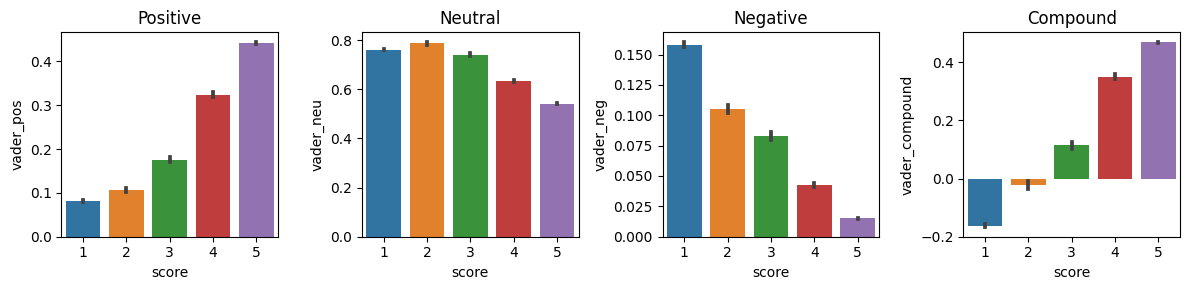

In [52]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
sns.barplot(data=shopee_vader_df, x='score', y='vader_pos', ax=axs[0])
sns.barplot(data=shopee_vader_df, x='score', y='vader_neu', ax=axs[1])
sns.barplot(data=shopee_vader_df, x='score', y='vader_neg', ax=axs[2])
sns.barplot(data=shopee_vader_df, x='score', y='vader_compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

In [53]:
# Create a range of compound score thresholds
shopee_thresholds_vader = np.linspace(-1, 1, 1000)

# Initialize lists to store accuracy scores and predicted labels
shopee_accuracy_scores_vader = []
shopee_predicted_labels_vader = []

# Iterate through the threshold range and calculate accuracy for each threshold
for threshold in shopee_thresholds_vader:
    shopee_vader_prediction = shopee_vader_df['vader_compound'].map(lambda x: 1 if x > threshold else 0)
    accuracy = accuracy_score(shopee_vader_df['sentimentLabel'], shopee_vader_prediction)
    shopee_accuracy_scores_vader.append(accuracy)
    shopee_predicted_labels_vader.append(shopee_vader_prediction)

# Find the threshold that maximizes accuracy
shopee_best_threshold = shopee_thresholds_vader[np.argmax(shopee_accuracy_scores_vader)]
shopee_best_accuracy = max(shopee_accuracy_scores_vader)

VADER's best accuracy score:  0.8252333333333334
Compound score threshold:  -0.0010010010010009784


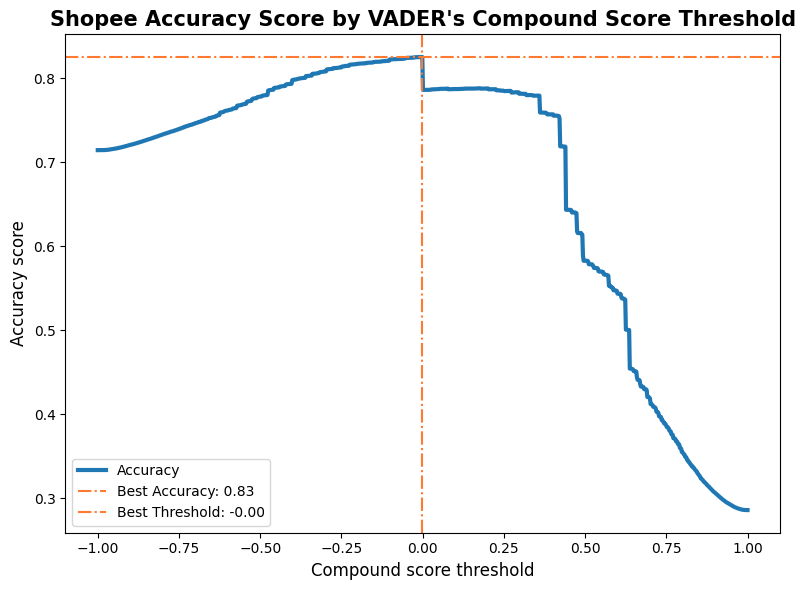

In [54]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the accuracy scores against compound score thresholds
plt.plot(shopee_thresholds_vader, shopee_accuracy_scores_vader, linewidth=3, label='Accuracy')

# Highlight the best accuracy score and threshold
plt.axhline(shopee_best_accuracy, linestyle='dashdot', color='#ff7930', label=f'Best Accuracy: {shopee_best_accuracy:.2f}')
plt.axvline(shopee_best_threshold, linestyle='dashdot', color='#ff7930', label=f'Best Threshold: {shopee_best_threshold:.2f}')
plt.title("Shopee Accuracy Score by VADER's Compound Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('Compound score threshold', size=12)
plt.legend()
plt.tight_layout()

print("VADER's best accuracy score: ", max(shopee_accuracy_scores_vader))
print('Compound score threshold: ', shopee_thresholds_vader[np.argmax(shopee_accuracy_scores_vader)])

In [55]:
# Prediction with compound threshold of -0.0010010010010009784
shopee_vader_df['vaderPrediction'] = shopee_vader_df['vader_compound'].map(lambda x: 1 if x > shopee_thresholds_vader[np.argmax(shopee_accuracy_scores_vader)] else 0)

In [56]:
# Confusion matrix
shopee_cm_vader = confusion_matrix(shopee_vader_df['sentimentLabel'], shopee_vader_df['vaderPrediction'])
shopee_cm_vader_df = pd.DataFrame(shopee_cm_vader, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
shopee_cm_vader_df

,Predicted Positive Review,Predicted Negative Review
Actual Positive Review,20955,21901
Actual Negative Review,4314,102830


In [57]:
# Classification report
print(classification_report(shopee_vader_df['sentimentLabel'], shopee_vader_df['vaderPrediction']))

              precision    recall  f1-score   support

           0       0.83      0.49      0.62     42856
           1       0.82      0.96      0.89    107144

    accuracy                           0.83    150000
   macro avg       0.83      0.72      0.75    150000
weighted avg       0.83      0.83      0.81    150000



In [58]:
# Positive reviews that were predicted to be positive reviews
shopee_vader_true_pos = shopee_vader_df[(shopee_vader_df['sentimentLabel']==1) & (shopee_vader_df['vaderPrediction']==1)]
shopee_vader_true_pos.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
1,0.0,0.492,0.508,0.4754,1,Its very nice app,nice app,5,1,1
2,0.0,0.192,0.808,0.6369,2,I love shoppe,love shoppe,5,1,1
3,0.0,0.448,0.552,0.5719,3,Im thankful for shoppe,im thankful shoppe,5,1,1
4,0.0,0.263,0.737,0.4215,4,Its helpful,helpful,5,1,1
5,0.0,0.000,1.000,0.4215,5,Satisfied,satisfied,4,1,1


In [59]:
# Negative reviews that were predicted to be negative reviews
shopee_vader_true_neg = shopee_vader_df[(shopee_vader_df['sentimentLabel']==0) & (shopee_vader_df['vaderPrediction']==0)]
shopee_vader_true_neg.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
0,0.056,0.944,0.000,-0.2500,0,Orders are stuck on warehouse for many days up...,orders stuck warehouse many days week sorted t...,3,0,0
14,1.000,0.000,0.000,-0.6588,14,Worst!,worst,1,0,0
27,0.150,0.850,0.000,-0.4577,27,Not free shipping at all! I always end up payi...,free shipping always end paying half shipping ...,1,0,0
33,0.261,0.739,0.000,-0.5984,33,"Name ng App shopee: NO SHIPPING FEE, pero may ...",name ng app shopee shipping fee pero may shipp...,3,0,0
68,0.175,0.762,0.063,-0.5267,68,Its buggy and it gets worse also they no longe...,buggy gets worse also longer allow use multipl...,1,0,0


In [60]:
# Positive reviews that were predicted to be negative reviews
shopee_vader_false_pos = shopee_vader_df[(shopee_vader_df['sentimentLabel']==0) & (shopee_vader_df['vaderPrediction']==1)]
shopee_vader_false_pos.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
12,0.0,1.000,0.000,0.0000,12,There are so many pop up ads,many pop ads,1,0,1
15,0.0,1.000,0.000,0.0000,15,Location is not accurate,location accurate,1,0,1
19,0.0,0.610,0.390,0.4927,19,I give 3 stars because its really good,give stars really good,3,0,1
38,0.0,1.000,0.000,0.0000,38,So many ads on my screen,many ads screen,1,0,1
40,0.0,0.873,0.127,0.4404,40,"Cannot zoom in, the font is too small even in ...",cannot zoom font small even tablet better dark...,3,0,1


In [61]:
# Negative reviews that were predicted to be positive reviews
shopee_vader_false_neg = shopee_vader_df[(shopee_vader_df['sentimentLabel']==1) & (shopee_vader_df['vaderPrediction']==0)]
shopee_vader_false_neg.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction
100,0.222,0.655,0.123,-0.6644,100,"Very good services shopee provides,,,except fo...",good services shopee provides except cash back...,5,1,0
142,0.125,0.825,0.050,-0.3919,142,I like the app you can literally just buy in h...,like app literally buy going mall somtimes ord...,5,1,0
167,0.264,0.500,0.236,-0.1027,167,Hate the new rule about voichers and free ship...,hate new rule voichers free shipping,4,1,0
258,0.432,0.417,0.151,-0.5719,258,ist okay . but sometimes alitlebit disappointed,ist okay sometimes alitlebit disappointed,4,1,0
328,0.126,0.785,0.089,-0.5106,328,"using this shopee apps long time ago, Sometime...",using shopee apps long time ago sometimes also...,5,1,0


# Roberta Pretrained Model Sentiment Analysis

Uses a model that has been trained on a sizable body of data. The word context in relation to other words is taken into account by the transformer model.

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

### Lazada

In [ ]:
laz_encoded_text = tokenizer(laz_rep_text, return_tensors='pt')
laz_output = model(**laz_encoded_text)
laz_scores = laz_output[0][0].detach().numpy()
laz_scores = softmax(laz_scores)
laz_scores_dict = {
    'roberta_neg' : laz_scores[0],
    'roberta_neu' : laz_scores[1],
    'roberta_pos' : laz_scores[2]
}
print(laz_scores_dict)

{'roberta_neg': 0.9610829, 'roberta_neu': 0.03374173, 'roberta_pos': 0.0051753507}


In [ ]:
def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    return probabilities[0].detach().numpy()

In [ ]:
laz_roberta_scores = []

for i, row in lazada_sen_df.iterrows():
    text = row['content']
    scores = get_sentiment_scores(text)
    laz_roberta_scores.append(scores)

In [ ]:
laz_roberta_df = pd.DataFrame(laz_roberta_scores, columns=['roberta_neg', 'roberta_neu', 'roberta_pos'])

In [ ]:
laz_roberta_df.head(5)

,roberta_neg,roberta_neu,roberta_pos
0,0.003297,0.008929,0.987775
1,0.002545,0.046670,0.950784
2,0.043729,0.786198,0.170073
3,0.005806,0.171929,0.822265
4,0.002638,0.015401,0.981961


In [ ]:
laz_VR_df = laz_vader_df.merge(laz_roberta_df, left_index=True, right_index=True)

In [ ]:
# Define a list to store accuracy scores
laz_accuracy_scores_roberta = []
laz_thresholds_roberta = np.linspace(-1, 1, 1000)

# Iterate through thresholds and calculate accuracy
for threshold in laz_thresholds_roberta:
    laz_roberta_prediction = (laz_VR_df['roberta_pos'] > threshold).astype(int)
    accuracy = accuracy_score(laz_VR_df['sentimentLabel'], laz_roberta_prediction)
    laz_accuracy_scores_roberta.append(accuracy)

# Find the best threshold and corresponding accuracy
laz_best_threshold_roberta = laz_thresholds_roberta[np.argmax(laz_accuracy_scores_roberta)]
laz_best_accuracy_roberta = max(laz_accuracy_scores_roberta)

RoBERTa's best accuracy score:  0.9124266666666667
RoBERTa sentiment score threshold:  0.077077077077077


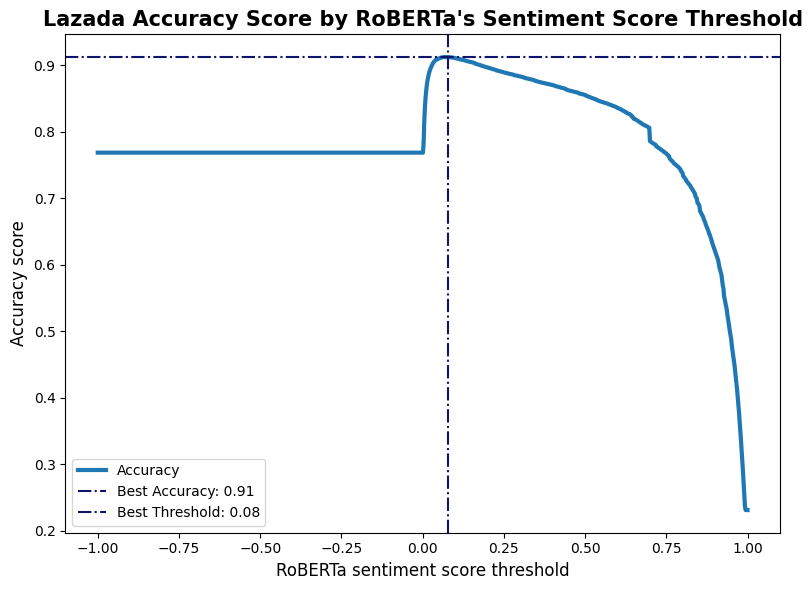

In [ ]:
# Create the plot for the roberta model
plt.figure(figsize=(8, 6))
plt.plot(laz_thresholds_roberta, laz_accuracy_scores_roberta, linewidth=3, label='Accuracy')

# Highlight the best accuracy score and threshold
plt.axhline(laz_best_accuracy_roberta, linestyle='dashdot', color='#0f146d', label=f'Best Accuracy: {laz_best_accuracy_roberta:.2f}')
plt.axvline(laz_best_threshold_roberta, linestyle='dashdot', color='#0f146d', label=f'Best Threshold: {laz_best_threshold_roberta:.2f}')
plt.title("Lazada Accuracy Score by RoBERTa's Sentiment Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('RoBERTa sentiment score threshold', size=12)
plt.legend()
plt.tight_layout()

print("RoBERTa's best accuracy score: ", laz_best_accuracy_roberta)
print('RoBERTa sentiment score threshold: ', laz_best_threshold_roberta)
plt.show()

In [ ]:
# Prediction with compound threshold of 0.08
laz_VR_df['robertaPrediction'] = laz_VR_df['roberta_pos'].map(lambda x: 1 if x > laz_thresholds_roberta[np.argmax(laz_accuracy_scores_roberta)] else 0)

In [ ]:
# Confusion matrix
laz_cm_roberta = confusion_matrix(laz_VR_df['sentimentLabel'], laz_VR_df['robertaPrediction'])
laz_cm_roberta_df = pd.DataFrame(laz_cm_roberta, columns=['Roberta Predicted Positive Review','Roberta Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
laz_cm_roberta_df

,Roberta Predicted Positive Review,Roberta Predicted Negative Review
Actual Positive Review,26808,7895
Actual Negative Review,5241,110056


In [ ]:
# Classification report
print(classification_report(laz_VR_df['sentimentLabel'], laz_VR_df['robertaPrediction']))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80     34703
           1       0.93      0.95      0.94    115297

    accuracy                           0.91    150000
   macro avg       0.88      0.86      0.87    150000
weighted avg       0.91      0.91      0.91    150000



In [ ]:
# Positive reviews that were predicted to be positive reviews
laz_roberta_true_pos = laz_VR_df[(laz_VR_df['sentimentLabel']==1) & (laz_VR_df['robertaPrediction']==1)]
laz_roberta_true_pos.head(5)

,content,contentAdj,score,sentimentLabel,vader_neg,vader_neu,vader_pos,vader_compound,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
0,i love this app...,love app,5,1,0.0,0.323,0.677,0.6369,1,0.003297,0.008929,0.987775,1
1,The best online apps,best online apps,5,1,0.0,0.417,0.583,0.6369,1,0.002545,0.046670,0.950784,1
2,Please add search feature for reward coin prod...,please add search feature reward coin products,4,1,0.0,0.500,0.500,0.7184,1,0.043729,0.786199,0.170073,1
3,Easy to order and cash on delivery.,easy order cash delivery,5,1,0.0,0.674,0.326,0.4404,1,0.005806,0.171929,0.822265,1
4,I love it... 😘,love,5,1,0.0,0.192,0.808,0.6369,1,0.002638,0.015401,0.981961,1


In [ ]:
# Negative reviews that were predicted to be negative reviews
laz_roberta_true_neg = laz_VR_df[(laz_VR_df['sentimentLabel']==0) & (laz_vader_df['vaderPrediction']==0)]
laz_roberta_true_neg.head(5)

,content,contentAdj,score,sentimentLabel,vader_neg,vader_neu,vader_pos,vader_compound,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
7,Their customer service is not helpful. Do not ...,customer service helpful ever pay debit pay it...,1,0,0.051,0.893,0.056,-0.1877,0,0.930972,0.064309,0.004718,0
17,Can't play video in the product page. It's bee...,play video product page months obviously bug s...,2,0,0.120,0.880,0.000,-0.2584,0,0.927107,0.068142,0.004750,0
35,Downloaded this app because i was directed by ...,downloaded app directed scam,1,0,0.346,0.654,0.000,-0.5719,0,0.836138,0.157097,0.006765,0
45,I also encountered problem in purchasing one i...,also encountered problem purchasing one item a...,2,0,0.130,0.870,0.000,-0.4019,0,0.750686,0.234109,0.015204,0
74,lazada is so prank..posting 49 pisos but when ...,lazada prank posting pisos u add cart posting ...,1,0,0.208,0.700,0.093,-0.6959,0,0.757562,0.202224,0.040215,0


In [ ]:
# Positive reviews that were predicted to be negative reviews
laz_roberta_false_pos = laz_VR_df[(laz_VR_df['sentimentLabel']==0) & (laz_VR_df['robertaPrediction']==1)]
laz_roberta_false_pos.head(5)

,content,contentAdj,score,sentimentLabel,vader_neg,vader_neu,vader_pos,vader_compound,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
6,The previous version is much better than the c...,previous version much better current new versi...,1,0,0.000,0.794,0.206,0.6369,1,0.331842,0.344898,0.323260,1
21,"Please, reform your entire interface. The gene...",please reform entire interface general public ...,2,0,0.084,0.743,0.172,0.3818,1,0.408703,0.433148,0.158149,1
90,UI/UX design Hi can make your UI design much s...,ui ux design hi make ui design much simplier w...,2,0,0.057,0.943,0.000,-0.1027,0,0.168920,0.356922,0.474158,1
96,I can order,order,1,0,0.000,1.000,0.000,0.0000,1,0.054940,0.665667,0.279392,1
128,Good choice,good choice,3,0,0.000,0.256,0.744,0.4404,1,0.018673,0.219163,0.762163,1


In [ ]:
# Negative reviews that were predicted to be positive reviews
laz_roberta_false_neg = laz_VR_df[(laz_VR_df['sentimentLabel']==1) & (laz_VR_df['robertaPrediction']==0)]
laz_roberta_false_neg.head(5)

,content,contentAdj,score,sentimentLabel,vader_neg,vader_neu,vader_pos,vader_compound,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
31,How about in nigara brunei darussalam You only...,nigara brunei darussalam thailand singgapore p...,5,1,0.000,1.000,0.000,0.0000,1,0.156449,0.806117,0.037434,0
59,It's 5 stars coz item deliveries are generally...,stars coz item deliveries generally fast compa...,5,1,0.000,0.942,0.058,0.5499,1,0.682024,0.265066,0.052910,0
83,Too fast,fast,4,1,0.000,1.000,0.000,0.0000,1,0.446588,0.489760,0.063652,0
114,Please restrict false information on product d...,please restrict false information product deta...,5,1,0.107,0.702,0.190,0.2500,1,0.432090,0.522652,0.045257,0
153,Do you have a confidential packaging ?? For th...,confidential packaging privacy customers,4,1,0.000,1.000,0.000,0.0000,1,0.102959,0.859521,0.037520,0


In [ ]:
laz_column_order = [
    'content', 'contentAdj', 'score', 'sentimentLabel', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'vaderPrediction', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'robertaPrediction'
]

laz_VR_sentiments_df = laz_VR_df[laz_column_order]
laz_VR_sentiments_df.columns

Index(['content', 'contentAdj', 'score', 'sentimentLabel', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'vaderPrediction',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'robertaPrediction'],
      dtype='object')

In [ ]:
laz_VR_sentiments_df.to_csv('lazada_reviews_sentiment.csv', index=False)     #Save the data

### Shopee

In [38]:
shopee_encoded_text = tokenizer(shopee_rep_text, return_tensors='pt')
shopee_output = model(**shopee_encoded_text)
shopee_scores = shopee_output[0][0].detach().numpy()
shopee_scores = softmax(shopee_scores)
shopee_scores_dict = {
    'roberta_neg' : shopee_scores[0],
    'roberta_neu' : shopee_scores[1],
    'roberta_pos' : shopee_scores[2]
}
print(shopee_scores_dict)

{'roberta_neg': 0.7515074, 'roberta_neu': 0.18728209, 'roberta_pos': 0.06121055}


In [39]:
shopee_encoded_text = tokenizer(shopee_rep_text, return_tensors='pt')
shopee_output = model(**shopee_encoded_text)
shopee_scores = shopee_output[0][0].detach().numpy()
shopee_scores = softmax(shopee_scores)
shopee_scores_dict = {
    'roberta_neg' : shopee_scores[0],
    'roberta_neu' : shopee_scores[1],
    'roberta_pos' : shopee_scores[2]
}
print(shopee_scores_dict)

{'roberta_neg': 0.7515074, 'roberta_neu': 0.18728209, 'roberta_pos': 0.06121055}


In [34]:
def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    return probabilities[0].detach().numpy()

In [35]:
shopee_roberta_scores = []

for i, row in shopee_sen_df.iterrows():
    text = row['content']
    scores = get_sentiment_scores(text)
    shopee_roberta_scores.append(scores)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [41]:
shopee_roberta_df = pd.DataFrame(shopee_roberta_scores, columns=['roberta_neg', 'roberta_neu', 'roberta_pos'])

In [42]:
shopee_roberta_df.head(5)

,roberta_neg,roberta_neu,roberta_pos
0,0.747981,0.232870,0.019149
1,0.002359,0.013705,0.983936
2,0.003687,0.019712,0.976601
3,0.002533,0.043220,0.954247
4,0.007659,0.218724,0.773616


In [62]:
shopee_VR_df = shopee_vader_df.merge(shopee_roberta_df, left_index=True, right_index=True)

In [63]:
# Define a list to store accuracy scores
shopee_accuracy_scores_roberta = []
shopee_thresholds_roberta = np.linspace(-1, 1, 1000)

# Iterate through thresholds and calculate accuracy
for threshold in shopee_thresholds_roberta:
    shopee_roberta_prediction = (shopee_VR_df['roberta_pos'] > threshold).astype(int)
    accuracy = accuracy_score(shopee_VR_df['sentimentLabel'], shopee_roberta_prediction)
    shopee_accuracy_scores_roberta.append(accuracy)

# Find the best threshold and corresponding accuracy
shopee_best_threshold_roberta = shopee_thresholds_roberta[np.argmax(shopee_accuracy_scores_roberta)]
shopee_best_accuracy_roberta = max(shopee_accuracy_scores_roberta)

RoBERTa's best accuracy score:  0.9093333333333333
RoBERTa sentiment score threshold:  0.1091091091091092


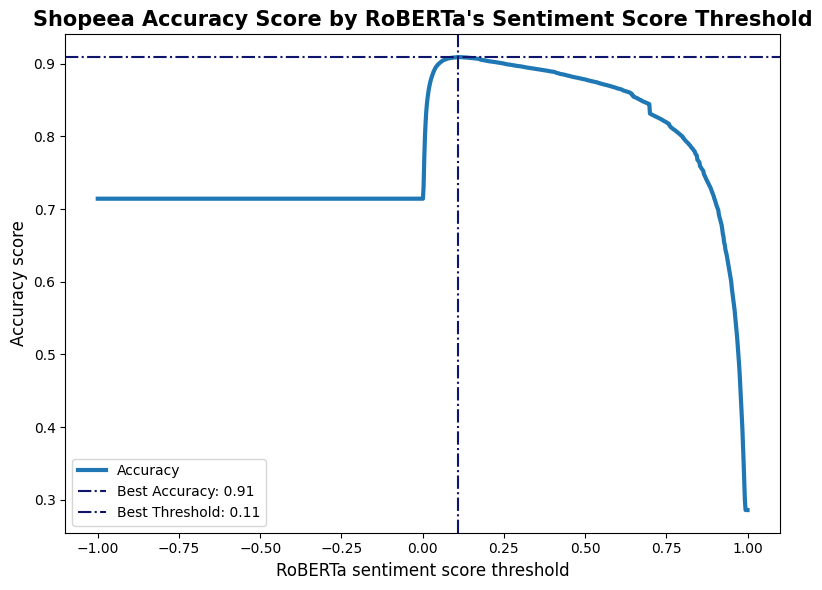

In [64]:
# Create the plot for the roberta model
plt.figure(figsize=(8, 6))
plt.plot(shopee_thresholds_roberta, shopee_accuracy_scores_roberta, linewidth=3, label='Accuracy')

# Highlight the best accuracy score and threshold
plt.axhline(shopee_best_accuracy_roberta, linestyle='dashdot', color='#0f146d', label=f'Best Accuracy: {shopee_best_accuracy_roberta:.2f}')
plt.axvline(shopee_best_threshold_roberta, linestyle='dashdot', color='#0f146d', label=f'Best Threshold: {shopee_best_threshold_roberta:.2f}')
plt.title("Shopeea Accuracy Score by RoBERTa's Sentiment Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('RoBERTa sentiment score threshold', size=12)
plt.legend()
plt.tight_layout()

print("RoBERTa's best accuracy score: ", shopee_best_accuracy_roberta)
print('RoBERTa sentiment score threshold: ', shopee_best_threshold_roberta)
plt.show()

In [65]:
# Prediction with compound threshold of 0.08
shopee_VR_df['robertaPrediction'] = shopee_VR_df['roberta_pos'].map(lambda x: 1 if x > shopee_thresholds_roberta[np.argmax(shopee_accuracy_scores_roberta)] else 0)

In [66]:
# Confusion matrix
shopee_cm_roberta = confusion_matrix(shopee_VR_df['sentimentLabel'], shopee_VR_df['robertaPrediction'])
shopee_cm_roberta_df = pd.DataFrame(shopee_cm_roberta, columns=['Roberta Predicted Positive Review','Roberta Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
shopee_cm_roberta_df

,Roberta Predicted Positive Review,Roberta Predicted Negative Review
Actual Positive Review,35185,7671
Actual Negative Review,5929,101215


In [67]:
# Classification report
print(classification_report(shopee_VR_df['sentimentLabel'], shopee_VR_df['robertaPrediction']))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     42856
           1       0.93      0.94      0.94    107144

    accuracy                           0.91    150000
   macro avg       0.89      0.88      0.89    150000
weighted avg       0.91      0.91      0.91    150000



In [68]:
# Positive reviews that were predicted to be positive reviews
shopee_roberta_true_pos = shopee_VR_df[(shopee_VR_df['sentimentLabel']==1) & (shopee_VR_df['robertaPrediction']==1)]
shopee_roberta_true_pos.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
1,0.0,0.492,0.508,0.4754,1,Its very nice app,nice app,5,1,1,0.002359,0.013705,0.983936,1
2,0.0,0.192,0.808,0.6369,2,I love shoppe,love shoppe,5,1,1,0.003687,0.019712,0.976601,1
3,0.0,0.448,0.552,0.5719,3,Im thankful for shoppe,im thankful shoppe,5,1,1,0.002533,0.043220,0.954247,1
4,0.0,0.263,0.737,0.4215,4,Its helpful,helpful,5,1,1,0.007659,0.218724,0.773616,1
5,0.0,0.000,1.000,0.4215,5,Satisfied,satisfied,4,1,1,0.009852,0.146118,0.844030,1


In [69]:
# Negative reviews that were predicted to be negative reviews
shopee_roberta_true_neg = shopee_VR_df[(shopee_VR_df['sentimentLabel']==0) & (shopee_vader_df['vaderPrediction']==0)]
shopee_roberta_true_neg.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
0,0.056,0.944,0.000,-0.2500,0,Orders are stuck on warehouse for many days up...,orders stuck warehouse many days week sorted t...,3,0,0,0.747981,0.232870,0.019149,0
14,1.000,0.000,0.000,-0.6588,14,Worst!,worst,1,0,0,0.872158,0.109012,0.018830,0
27,0.150,0.850,0.000,-0.4577,27,Not free shipping at all! I always end up payi...,free shipping always end paying half shipping ...,1,0,0,0.578697,0.354542,0.066760,0
33,0.261,0.739,0.000,-0.5984,33,"Name ng App shopee: NO SHIPPING FEE, pero may ...",name ng app shopee shipping fee pero may shipp...,3,0,0,0.364136,0.595815,0.040049,0
68,0.175,0.762,0.063,-0.5267,68,Its buggy and it gets worse also they no longe...,buggy gets worse also longer allow use multipl...,1,0,0,0.960557,0.036284,0.003159,0


In [70]:
# Positive reviews that were predicted to be negative reviews
shopee_roberta_false_pos = shopee_VR_df[(shopee_VR_df['sentimentLabel']==0) & (shopee_VR_df['robertaPrediction']==1)]
shopee_roberta_false_pos.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
19,0.000,0.610,0.390,0.4927,19,I give 3 stars because its really good,give stars really good,3,0,1,0.001492,0.013104,0.985404,1
71,0.000,0.674,0.326,0.4404,71,"its good, the delivery is so fast",good delivery fast,3,0,1,0.002869,0.016042,0.981090,1
75,0.000,0.508,0.492,0.4404,75,Good performance about shoppers,good performance shoppers,2,0,1,0.011370,0.144336,0.844294,1
96,0.106,0.894,0.000,-0.5504,96,I am a shopee user for 2 years and been using ...,shopee user years using shopee app use free sh...,1,0,0,0.229537,0.492602,0.277862,1
98,0.000,0.256,0.744,0.4404,98,Good quality,good quality,1,0,1,0.029416,0.325991,0.644593,1


In [71]:
# Negative reviews that were predicted to be positive reviews
shopee_roberta_false_neg = shopee_VR_df[(shopee_VR_df['sentimentLabel']==1) & (shopee_VR_df['robertaPrediction']==0)]
shopee_roberta_false_neg.head(5)

,vader_neg,vader_neu,vader_pos,vader_compound,Id,content,contentAdj,score,sentimentLabel,vaderPrediction,roberta_neg,roberta_neu,roberta_pos,robertaPrediction
7,0.000,0.722,0.278,0.4019,7,how does the clip help you understand literature,clip help understand literature,5,1,1,0.114928,0.838639,0.046433,0
34,0.000,1.000,0.000,0.0000,34,Accommodating seller,accommodating seller,4,1,1,0.120666,0.800476,0.078858,0
54,0.065,0.822,0.113,0.3561,54,shopee do not Disappoint the only thing that i...,shopee disappoint thing think must improve low...,5,1,1,0.499791,0.427281,0.072928,0
87,0.000,1.000,0.000,0.0000,87,Shape Des cawnt,shape des cawnt,5,1,1,0.242224,0.666781,0.090996,0
122,0.000,1.000,0.000,0.0000,122,Mas okey umorder dito..,mas okey umorder dito,5,1,1,0.105826,0.840238,0.053936,0


In [72]:
shopee_column_order = [
    'content', 'contentAdj', 'score', 'sentimentLabel', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'vaderPrediction', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'robertaPrediction'
]

shopee_VR_sentiments_df = shopee_VR_df[shopee_column_order]
shopee_VR_sentiments_df.columns

Index(['content', 'contentAdj', 'score', 'sentimentLabel', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'vaderPrediction',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'robertaPrediction'],
      dtype='object')

In [74]:
shopee_VR_sentiments_df.to_csv('shopee_reviews_sentiment.csv', index=False)     #Save the data